<a href="https://colab.research.google.com/github/DanielDekhtyar/AI-Accelerator/blob/main/Final%20Project/notebooks/Time%20Series%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Dropout, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# Loading the S&P500 data into a DataFrame
snp = pd.read_csv('snp_data.csv')

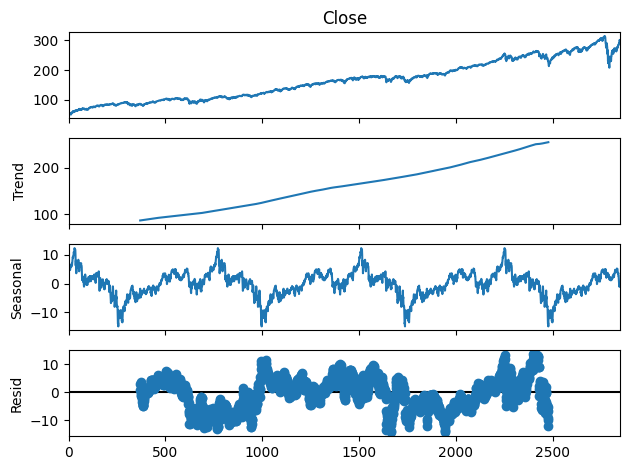

In [ ]:
#עונה ומגמה בעזרת seasonal_decompose
result = seasonal_decompose(snp['Close'],
                            model='additive',
                            period=740)
result.plot()
plt.show()

In [ ]:
#נורמליזציה
scaler = MinMaxScaler (feature_range  =(-1,1))
snp['Close'] = scaler.fit_transform(snp[['Close']])

In [ ]:
#חלונות
def create_sequences (series, window_size):
  X,y =[],[]
  for i in range(len(series)-window_size):
    X.append(series[i:window_size +i])
    y.append(series[window_size +i])
  return np.array(X), np.array(y)

In [ ]:
window_size =12 #מחזור של שנה
X, y = create_sequences(snp['Close'].values, window_size)

In [ ]:
#train test split : testing the future
split_time = int(len(X)*0.8)
X_train, X_valid = X[:split_time], X[split_time:]
y_train, y_valid = y[:split_time], y[split_time:]

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1], 1))

In [ ]:
model = Sequential([
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(1)
    ])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate if validation loss stagnates
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # Wait 2 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='stock_price_prediction.keras',  # Save model to this file
    monitor='val_loss',  # Track validation loss
    save_best_only=True,  # Save only the best version of the model
    mode='max',  # "max" since we want to maximize aloss
    verbose=1  # Print a message when saving the model
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=5
)

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks = [reduce_lr, checkpoint, early_stoping]
)

y_pred = model.predict(X_valid)

# מחזירים את הנתונים לסקאלה המקורית
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_valid = scaler.inverse_transform(y_valid.reshape(-1, 1))

# יצירת ציר זמן
time_valid = snp['Date'][split_time + window_size:]

Epoch 1/100
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0373
Epoch 1: val_loss improved from -inf to 0.00484, saving model to stock_price_prediction.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0363 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/100
65/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6819e-04
Epoch 2: val_loss did not improve from 0.00484
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6947e-04 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 3/100
68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7110e-04
Epoch 3: val_loss did not improve from 0.00484
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7119e-04 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 4/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0258e-04
Epoch 4: val_loss did not improve from 0.00484
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0176e-04 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6954e-04
Epoch 5: val_l

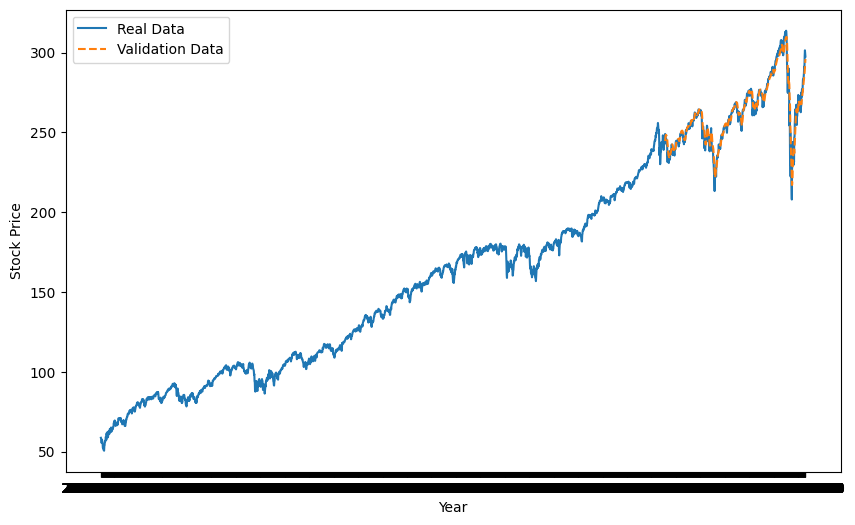

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(snp['Date'],
         scaler.inverse_transform(snp['Close'].values.reshape(-1, 1)),
         label="Real Data")
plt.plot(time_valid, y_pred, label="Validation Data", linestyle="dashed")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.show()